# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

The objective is to help an entrepreneur to find the best place to open a new gastronomic **Italian restaurant** in **Manhattan**.
For this study we consider the "restaurant market" is very mature in Manhattan. It means that we will consider that places where the number of restaurant is very low are locations with low potential (e.g. residential places) and not locations with high potential.
For Manhattan, the notion of city center does not really exist so we cannot measure the distance between potential locations and a "city center".
As a result, the approach taken to solve the problem will be the following one:
1. **find zones with a certain density of restaurants**
1. segment those zones in order to **find different profiles** (e.g. Asian/Chinese profile, Latin/Italian profile, TexMex...)
1. within each profile/segment, **assess the potential of each zone** (e.g. a zone being tagged as Latin/Italian with fewer Italian restaurant than average)

## Data <a name="data"></a>

The first need is to have a **map of Manhattan** (with neighborhoods, coordinates of Manhattan frontiers...).  
Based on this map, we will first define zones: a zone being defined as a perimeter around a given place.  

We will then create a grid, within Manhattan frontiers, with a certain distance (e.g. d = 500m) between nodes and make sure zones cover the full Manhattan area (at this stage we do not care if zones overlap) : the radius of each zone will be equal to d/sqrt(2).  
For each zone we will retrieve the **list of restaurants** (whatever the type) using **Foursquare** data. We will then compute the density of each type of restaurant and segment/cluster the different zones.  
Among the different clusters, we will be interested by zones with a "lack" of Italian restaurants: this lack will be computed as the distance between the density of Italian restaurant of the zone and the average of the same density for the cluster, only for zones being under the average.  

Once zones with the best potential have been found, we will **get the ratings of the Italian restaurants** of the top 20 zones in order to assess the quality of the future competitors.  
In order to let the entrepreneur decide, the results of the study will be **displayed as a map**, with zones colored depending on their potential, and restaurants with **good ratings (>8) displayed on the map** for the top 20 zones

### Manhattan zones

Based on the Manhattan map, we will create a grid, each node of the grid being the center of a zone. Nodes / zones will be used all along the study.

In [1]:
import numpy as np # library to handle data in a vectorized manner
import random
import math
!pip install pyproj
import pyproj


import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.5f}'.format

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

print('Libraries imported.')

Libraries imported.


In [2]:
!pip install shapely
from shapely.geometry import Polygon, Point
from shapely.ops import cascaded_union

In [3]:
!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Let's create a grid over Manhattan map. The distance between nodes will be set to 400m in order to make sure the number of restaurants in each zone is under 100 (Foursquare limitation)


In order to make Folium and Foursquare work together, we will need to convert Cartesian 2D coordinate to longitude/latitude degrees

In [4]:
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=18, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=18, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

In [5]:
LIMIT = 100
nodes_distance = 400 #distance in meters between 2 nodes
radius = nodes_distance / math.sqrt(3) #radius of each zone in order to make sure the full surface is covered

In [6]:
!wget -q -O 'new_york.geojson' https://raw.githubusercontent.com/Aurelrobert/Coursera_Capstone/master/NY.geojson
print('Data downloaded!')

Data downloaded!


In [7]:
with open('new_york.geojson') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

Get all neighborhoods with their frontiers (defined as polygons)

In [8]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'Polygon'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['neighborhood']
        
    neighborhood_polygon = Polygon(data['geometry']['coordinates'][0])
    neighborhood_lon, neighborhood_lat = neighborhood_polygon.centroid.coords[0]  
    neighborhoods = neighborhoods.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon,
                                              'Polygon': neighborhood_polygon,
                                             }, ignore_index=True)

In [9]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude,Polygon
0,Bronx,Allerton,40.86473,-73.85998,POLYGON ((-73.84859700000018 40.87167000000012...
1,Queens,Alley Pond Park,40.75026,-73.74451,"POLYGON ((-73.74333268196389 40.7388830992604,..."
2,Staten Island,Arden Heights,40.55481,-74.17946,"POLYGON ((-74.169827 40.56107800000017, -74.16..."
3,Staten Island,Arlington,40.64295,-74.15975,POLYGON ((-74.15974815874296 40.64141652579018...
4,Staten Island,Arrochar,40.59319,-74.07218,POLYGON ((-74.06077989345394 40.59318800468343...


Keep only Manhattan neighborhoods

In [10]:
manhattan = neighborhoods[neighborhoods['Borough']=='Manhattan']
manhattan.head()

,Borough,Neighborhood,Latitude,Longitude,Polygon
8,Manhattan,Battery Park City,40.71125,-74.01608,"POLYGON ((-74.01375400000018 40.71369, -74.014..."
49,Manhattan,Central Park,40.78247,-73.96557,POLYGON ((-73.94965699268657 40.79706872127114...
51,Manhattan,Chelsea,40.74661,-73.99981,POLYGON ((-73.99346400122367 40.75218999709955...
53,Manhattan,Chinatown,40.71578,-73.99571,POLYGON ((-73.99999096973443 40.71797674709695...
56,Manhattan,Civic Center,40.71387,-74.00285,"POLYGON ((-73.9979936899674 40.71272235466727,..."


Check that the union of all Manhattan neighborhoods gives Manhattan

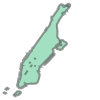

In [11]:
manhattan_polygon = cascaded_union(manhattan['Polygon'].to_list())
manhattan_polygon

Now let's create the grid over Manhattan map. Each zone that does not intersect Manhattan is excluded

In [12]:
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_step = nodes_distance
y_step = nodes_distance * k
manhattan_nodes = []
ini_x, cur_y = lonlat_to_xy(manhattan_polygon.bounds[0], manhattan_polygon.bounds[1])
end_x, end_y = lonlat_to_xy(manhattan_polygon.bounds[2], manhattan_polygon.bounds[3])
cur_row = 0
while cur_y < end_y:
    x_offset = x_step/2 if cur_row%2==0 else 0
    cur_x = ini_x - x_offset
    cur_row += 1
    while cur_x < end_x:
        node = Point(xy_to_lonlat(cur_x, cur_y))
        cur_x += x_step
        if manhattan_polygon.intersects(node.buffer(xy_to_lonlat(0,nodes_distance/2)[1] - xy_to_lonlat(0,0)[1])):
            manhattan_nodes.append(node)
    cur_y += y_step
print("{} nodes created".format(len(manhattan_nodes)))

517 nodes created


Lets define a **draw_map** function is order to display easily Manhattan maps for the rest of the study

In [13]:
def draw_map(data, latitude='Latitude', longitude='Longitude', z_value=None, cluster=None, labels=None, separator=", ", zoom=11, radius=radius, show_radius=False, show_marker=True):
    my_map = folium.Map(location=[(data[latitude].max() + data[latitude].min())/2, (data[longitude].max() + data[longitude].min())/2], zoom_start=zoom)
    #z_value: column name for the z_value, to display Circles / CircleMarkers in different colors based on their value
    #cluster: display Circles in different color based on the cluster value (if no z_value provided)
    
    if not z_value is None:
        # set color scheme for z_values
        values = minmax_scale(data[z_value])
        color_list = [colors.rgb2hex(cm.RdYlGn(v)) for v in values]
        
    if not cluster is None:
        nb_colors = len(data[data[cluster].notna()][cluster].unique())

        # set color scheme for the clusters
        colors_array = cm.rainbow(np.linspace(0, 1, nb_colors))
        rainbow = [colors.rgb2hex(i) for i in colors_array]
        color_list = data[data[cluster].notna()][cluster].map(lambda x: rainbow[int(x)-1]).values.tolist()
    
    # add markers to map
    for index, row in data.reset_index().iterrows():
        if not labels is None:
            label = separator.join(["{}: ".format(lab) + str(row[lab]) for lab in labels])
            if not cluster is None:
                label = label + separator + "Cluster: {}".format(row[cluster])
            if not z_value is None:
                label = label + separator + "{}: {}".format(z_value, row[z_value])
            label = folium.Popup(label, parse_html=True)
        else:
            label = None
        
        if not z_value is None:
            if np.isnan(row[z_value]):
                color = "#666666"
            else:
                color = color_list[index]
        else:
            if not cluster is None:
                if np.isnan(row[cluster]):
                    color = "#666666"
                else:
                    color = color_list[int(row[cluster])]
                    #color = rainbow[int(row[cluster])-1]
            else:
                color = 'blue'
        if show_radius:
            if show_marker:
                opacity = 0.3
                fill_opacity = 0.2
            else:
                opacity = 1
                fill_opacity = 0.8
            folium.Circle(
                [row[latitude], row[longitude]],
                radius=radius,
                color=color,
                opacity=opacity,
                fill=True,
                fill_color=color,
                fill_opacity=fill_opacity).add_to(my_map) 
        if show_marker:
                folium.CircleMarker(
                [row[latitude], row[longitude]],
                radius=5,
                popup=label,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                parse_html=False).add_to(my_map)
    return my_map

Display the grid in order to check it is well defined

In [14]:
manhattan_nodes_df = pd.DataFrame([[node.x, node.y] for node in manhattan_nodes])
manhattan_nodes_df.columns = ["Longitude", "Latitude"]
manhattan_nodes_df.index.name = "Node"
draw_map(manhattan_nodes_df, zoom=12, show_radius=True, radius=radius)

### Foursquare

In [15]:
CLIENT_ID = 'PIPW1GIU5V2TFGIOS1MRS0P5M4PTBK2RGKB2TLGMVCXBZII2' # your Foursquare ID
CLIENT_SECRET = 'KGALOYY3DXAONDERPV3OEGO4SFY004EYYEUG4KBACOQJZXLD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PIPW1GIU5V2TFGIOS1MRS0P5M4PTBK2RGKB2TLGMVCXBZII2
CLIENT_SECRET:KGALOYY3DXAONDERPV3OEGO4SFY004EYYEUG4KBACOQJZXLD


In [16]:
def getNearbyVenues(nodes, latitudes, longitudes, radius=radius, section='food'):
    
    venues_list=[]
    for node, lat, lng in zip(nodes, latitudes, longitudes):
        print(node, end=" ")
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            section,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        try:
            results = results["response"]['groups'][0]['items']
            print("({})".format(len(results)), end=" | ")
            # return only relevant information for each nearby venue
            venues_list.append([(
                node, 
                lat, 
                lng, 
                v['venue']['id'], 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print(results)
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Node', 
                  'Node Latitude', 
                  'Node Longitude', 
                  'Venue ID', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get all Manhattan venues, zone by zone

In [17]:
manhattan_venues = getNearbyVenues(nodes=manhattan_nodes_df.index,
                                   latitudes=manhattan_nodes_df['Latitude'],
                                   longitudes=manhattan_nodes_df['Longitude']
                                  )

0 (0) | 1 (1) | 2 (0) | 3 (0) | 4 (0) | 5 (3) | 6 (2) | 7 (8) | 8 (0) | 9 (0) | 10 (2) | 11 (3) | 12 (0) | 13 (1) | 14 (0) | 15 (2) | 16 (0) | 17 (3) | 18 (22) | 19 (1) | 20 (5) | 21 (7) | 22 (46) | 23 (9) | 24 (4) | 25 (11) | 26 (33) | 27 (46) | 28 (35) | 29 (2) | 30 (1) | 31 (2) | 32 (15) | 33 (34) | 34 (38) | 35 (10) | 36 (17) | 37 (0) | 38 (1) | 39 (0) | 40 (0) | 41 (34) | 42 (4) | 43 (34) | 44 (1) | 45 (41) | 46 (27) | 47 (27) | 48 (11) | 49 (4) | 50 (1) | 51 (0) | 52 (10) | 53 (33) | 54 (22) | 55 (37) | 56 (31) | 57 (37) | 58 (7) | 59 (4) | 60 (4) | 61 (2) | 62 (18) | 63 (28) | 64 (24) | 65 (57) | 66 (31) | 67 (43) | 68 (26) | 69 (2) | 70 (1) | 71 (0) | 72 (14) | 73 (35) | 74 (12) | 75 (52) | 76 (28) | 77 (27) | 78 (33) | 79 (7) | 80 (0) | 81 (0) | 82 (2) | 83 (32) | 84 (47) | 85 (20) | 86 (33) | 87 (57) | 88 (45) | 89 (22) | 90 (2) | 91 (0) | 92 (15) | 93 (36) | 94 (71) | 95 (10) | 96 (45) | 97 (58) | 98 (38) | 99 (1) | 100 (0) | 101 (3) | 102 (40) | 103 (61) | 104 (15) | 105 (2

Check the number (and the distribution by quartile) of restaurants over all zones

In [18]:
number_venues = manhattan_venues.groupby('Node').count()[['Venue']]
number_venues.columns = ['Node Number Venues']
number_venues.describe()

,Node Number Venues
count,430.00000
mean,16.93023
std,14.45642
min,1.00000
25%,4.00000
50%,13.00000
75%,27.75000
max,71.00000


In [19]:
manhattan_venues = manhattan_venues.join(number_venues, on='Node')
manhattan_venues.head()

,Node,Node Latitude,Node Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Node Number Venues
0,1,40.68270,-74.02170,4d6ee122b45b59417c6a6778,Kimchi Taco Truck,40.68216,-74.02331,Food Truck,1
1,5,40.68914,-74.04527,4c3f973dcc410f47db6aa861,Statue of Liberty Crown Cafe,40.68986,-74.04635,American Restaurant,3
2,5,40.68914,-74.04527,558c3c89498eb8fa9fad3f2f,"Bill's ""World Famous"" Lemonade",40.69017,-74.04691,Food Truck,3
3,5,40.68914,-74.04527,4caf5c8c75ebb60c74a3bbad,Liberty Island Food Court,40.68985,-74.04640,Food Court,3
4,6,40.68894,-74.02161,582270dab078be59c611c926,Jolly Fat Pig,40.68917,-74.02233,Food Truck,2


## Methodology <a name="methodology"></a>

Now we have all Manhattan venues, we will first segment the differents zones in order to identify zones profiles.  
Segment zones based on the different restaurant types density. In order to have a significant number of restaurants in the zone, we keep only the **2 first quartiles** (i.e. **zones with more than 13 restaurants**)  

Then, for each cluster we will consider that zones having a **density under the cluster average** (for a given type of restaurant) **has a potential to increase**.  
This will give the **list of 20 zones** (with the highest potential) we will focus on.  

For the selected zones, we will then retrieve the **ratings of the potential competitors** in order to find the best place to open a nwe restaurant (i.e. not too close from a competitor with a good rating - i.e. more than 8).  

Results will be **displayed in a map**, with the 20 selected zones and the places where the competitors are located.

## Analysis <a name="analysis"></a>

Let's start by segmenting our zones. We keep only zones with more than 13 restaurants.

In [20]:
def node_profile(neighborhood_venues):
    temp_df = pd.get_dummies(neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

    temp_df['Node'] = neighborhood_venues['Node'] 

    # move neighborhood column to the first column
    fixed_columns = [temp_df.columns[-1]] + list(temp_df.columns[:-1])
    temp_df = temp_df[fixed_columns]

    return temp_df.groupby('Node').mean().reset_index()

In [21]:
node_profiles = node_profile(manhattan_venues[manhattan_venues['Node Number Venues']>13])
node_profiles.head()

,Node,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,18,0.00000,0.00000,0.09091,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.09091,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.09091,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.09091,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.13636,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,22,0.00000,0.00000,0.04348,0.00000,0.00000,0.00000,0.00000,0.00000,0.02174,0.02174,0.02174,0.00000,0.00000,0.00000,0.00000,0.00000,0.02174,0.00000,0.00000,0.02174,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.02174,0.00000,0.00000,0.00000,0.00000,0.00000,0.04348,0.00000,0.00000,0.02174,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.19565,0.00000,0.00000,0.00000,0.02174,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000

Get the most common venues of each zone in order to easy further anaylsis (and understand the segmentation)

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


def node_top_venues(neigh_profile, num_top_venues = 10):

    indicators = ['st', 'nd', 'rd'] + (num_top_venues -3) * ['th']

    # create columns according to number of top venues
    columns = ['Node']
    for ind in np.arange(num_top_venues):
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))

    # create a new dataframe
    top_venues = pd.DataFrame(columns=columns)
    top_venues['Node'] = neigh_profile['Node']

    for ind in np.arange(neigh_profile.shape[0]):
        top_venues.iloc[ind, 1:] = return_most_common_venues(neigh_profile.iloc[ind, :], num_top_venues)

    return top_venues

Define the best number of clusters

In [24]:
def draw_elbow(features, k_max=10):
    plt.plot()

    distortions = []
    K = range(1, k_max)
    for k in K:
        print("{}...".format(k), end="")
        kmeanModel = KMeans(n_clusters=k).fit(features)
        distortions.append(sum(np.min(cdist(features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / features.shape[0])

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

1...2...3...4...5...6...7...8...9...10...11...12...13...14...

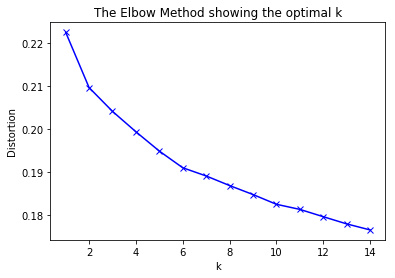

In [25]:
node_profiles_features = node_profiles.drop('Node', 1)
draw_elbow(node_profiles_features, 15)

The **number of cluster** we will use for the rest of the study is **10**

In [45]:
# run k-means clustering
kmeans = KMeans(n_clusters=10, random_state=0).fit(node_profiles_features)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([1, 8, 1, 3, 7, 1, 1, 1, 2, 7, 1, 9, 9, 2, 7, 1, 9, 9, 7, 3],
      dtype=int32)

Build a **Dataframe** with nodes coordinates, **most common venues**, **restaurant density** and **cluster labels**

In [44]:
top_venus = node_top_venues(node_profiles)
top_venus.head()

,Node,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,18,Sandwich Place,Mexican Restaurant,Deli / Bodega,American Restaurant,Pizza Place,Lebanese Restaurant,Salad Place,Snack Place,Fast Food Restaurant,Food
1,22,Food Truck,Pizza Place,Sandwich Place,Japanese Restaurant,Seafood Restaurant,American Restaurant,Salad Place,Mexican Restaurant,Deli / Bodega,Steakhouse
2,26,Pizza Place,Food Truck,Donut Shop,Café,Chinese Restaurant,New American Restaurant,Sandwich Place,American Restaurant,Deli / Bodega,Diner
3,27,American Restaurant,Donut Shop,Deli / Bodega,Mediterranean Restaurant,Sandwich Place,Salad Place,Italian Restaurant,Vegetarian / Vegan Restaurant,Falafel Restaurant,Pizza Place
4,28,Italian Restaurant,Restaurant,Mexican Restaurant,Café,Bistro,New American Restaurant,Sandwich Place,Seafood Restaurant,Sushi Restaurant,Hot Dog Joint


In [46]:
# add clustering labels
top_venus.insert(0, 'Cluster Labels', kmeans.labels_)

node_merged = manhattan_nodes_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
node_merged = node_merged.join(top_venus.set_index('Node'), on='Node')
node_merged = node_merged.join(node_profiles.set_index('Node'), on='Node')

node_merged[~node_merged['Cluster Labels'].isna()].head()

,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
Node,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18,-74.01196,40.70134,1.00000,Sandwich Place,Mexican Restaurant,Deli / Bodega,American Restaurant,Pizza Place,Lebanese Restaurant,Salad Place,Snack Place,Fast Food Restaurant,Food,0.00000,0.00000,0.09091,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.09091,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.09091,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.09091,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.13636,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,

And display the different clusters on a map

In [47]:
draw_map(node_merged, zoom=12, labels=["Node"], cluster="Cluster Labels", separator=' | ', show_radius=True, show_marker=False, radius = nodes_distance/2)

We see that generally zones of the same cluster are grouped (we have very few single zones surrounded by zones from another cluster)

Define the type or restaurant the entrepreneur wants to open. In our case, it is an Italian Restaurant.  
As Pizza Places can also be competitors we will consider both **Italian Restaurant** and **Pizza Place**

In [48]:
new_restaurant_type = ["Pizza Place", "Italian Restaurant"]
node_merged["New Restaurant Type"] = node_merged[new_restaurant_type].sum(axis=1)
node_merged.head(20)

,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,New Restaurant Type
Node,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-74.02643,40.68274,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00000
1,-74.02170,40.68270,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n

Compute the **average density** of italian restaurants for each cluster

In [49]:
restaurant_type_average_density = node_merged[['Cluster Labels', "New Restaurant Type"]].groupby(['Cluster Labels']).mean()
restaurant_type_average_density.columns= ['Cluster Average Dentity']
restaurant_type_average_density

,Cluster Average Dentity
Cluster Labels,
0.00000,0.12590
1.00000,0.16668
2.00000,0.10707
3.00000,0.08675
4.00000,0.15469
5.00000,0.15530
6.00000,0.28439
7.00000,0.14134
8.00000,0.08003


And **merge it** in the global node Dataframe

In [50]:
node_merged = node_merged.join(restaurant_type_average_density, on='Cluster Labels')
node_merged[~node_merged['Cluster Labels'].isna()].head()

,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,New Restaurant Type,Cluster Average Dentity
Node,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18,-74.01196,40.70134,1.00000,Sandwich Place,Mexican Restaurant,Deli / Bodega,American Restaurant,Pizza Place,Lebanese Restaurant,Salad Place,Snack Place,Fast Food Restaurant,Food,0.00000,0.00000,0.09091,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.09091,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.09091,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.09091,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.13636,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.

Compute the **improvement potential**. We define it as the difference between the average density of the cluster and the density of the zone (floored to 0)

In [51]:
node_merged['Improvement Potential'] = (node_merged['Cluster Average Dentity'] - node_merged["New Restaurant Type"]).map(lambda x: max(x, 0))
node_merged['Improvement Potential'].replace(0, np.NaN, inplace=True)
node_merged[~node_merged['Cluster Labels'].isna()].head()

,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,New Restaurant Type,Cluster Average Dentity,Improvement Potential
Node,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18,-74.01196,40.70134,1.00000,Sandwich Place,Mexican Restaurant,Deli / Bodega,American Restaurant,Pizza Place,Lebanese Restaurant,Salad Place,Snack Place,Fast Food Restaurant,Food,0.00000,0.00000,0.09091,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.09091,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.09091,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.09091,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.13636,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0

In [52]:
node_merged[['Improvement Potential']].describe()

,Improvement Potential
count,107.00000
mean,0.04085
std,0.03069
min,0.00001
25%,0.01592
50%,0.03499
75%,0.05747
max,0.14134


**Diplay the zones with their potential**. Excluded zones (due to the low number of restaurants) and zones without potential are displayed in grey

In [53]:
draw_map(node_merged, zoom=12, z_value="Improvement Potential", show_radius=True, show_marker=False, radius = nodes_distance/2)

Zones with high potentials come from different clusters. We see that Little Italy does not have any potential and Chinatown has a rather good potential, which is logic

Keep only the **top 20** zones

In [54]:
nodes_top20 = node_merged.nlargest(20, "Improvement Potential")
nodes_top20

,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,New Restaurant Type,Cluster Average Dentity,Improvement Potential
Node,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
406,-73.94390,40.81308,7.00000,African Restaurant,Caribbean Restaurant,French Restaurant,Seafood Restaurant,Tapas Restaurant,Chinese Restaurant,Café,Fried Chicken Joint,Southern / Soul Food Restaurant,Vegetarian / Vegan Restaurant,0.00000,0.14286,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.07143,0.00000,0.00000,0.00000,0.14286,0.00000,0.00000,0.07143,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.14286,0.07143,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.14286,0.00000,0.00000,0.00000,0.00000,0.00000,

For the top 20, **get all the italian restaurant** in order to retrieve their rating

In [55]:
competitors_list = manhattan_venues[(manhattan_venues['Venue Category'].isin(new_restaurant_type)) & (manhattan_venues['Node'].isin(nodes_top20.index))]
print(competitors_list.shape)
competitors_list.head()

(20, 9)


,Node,Node Latitude,Node Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Node Number Venues
265,33,40.71068,-74.00945,5c6f03f30802d4002c16884c,Joe’s Pizza,40.71032,-74.00769,Pizza Place,34
275,33,40.71068,-74.00945,5447e0b2498e49ee7c7b1dc0,Da Claudio,40.71083,-74.00764,Italian Restaurant,34
289,33,40.71068,-74.00945,59792b2403369334be043a56,Vino e Grano,40.70995,-74.01157,Italian Restaurant,34
684,57,40.71676,-73.99042,56c3c626cd106998d2b196d0,Scarr's Pizza,40.71534,-73.99165,Pizza Place,37
702,57,40.71676,-73.99042,52b5d6b6498e149068fbea80,Williamsburg Pizza,40.71830,-73.99105,Pizza Place,37


In [56]:
competitors_id_list = competitors_list['Venue ID'].unique()

In [57]:
def restaurants_rating(venue_id_list):
    df = pd.DataFrame(venue_id_list, columns=["Venue ID"])
    ratings=[]
    exceeded_quota = False
    for venue_id in venue_id_list:
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        if result['meta']['code'] != 200 and result['meta']['errorType']=='quota_exceeded':
            exceeded_quota = True
            ratings.append(round(max(0, min(random.gauss(6, 2), 10)), 1))
        else:
            result['response']['venue']
            try:
                ratings.append(result['response']['venue']['rating'])
            except:
                ratings.append(np.nan)
        print(venue_id, end=' | ')
    df["Rating"] = ratings
    if exceeded_quota:
        print("")
        print("!!! Quota Exceeded !!!")
    return df

**Get the ratings** for the list of restaurants

In [58]:
competitors_rating = restaurants_rating(competitors_id_list)
competitors_rating.head()

5c6f03f30802d4002c16884c | 5447e0b2498e49ee7c7b1dc0 | 59792b2403369334be043a56 | 56c3c626cd106998d2b196d0 | 52b5d6b6498e149068fbea80 | 51c4bbd02fc62fbffb241861 | 4bbf6b6430c99c74302a5511 | 4c6f137cd97fa14356fdf1ca | 5d4893bdf7552900089f9f5e | 4e473b97fa76a07fde65b0d8 | 4a610549f964a520b0c11fe3 | 459395b7f964a52047401fe3 | 4a78f3e2f964a520b0e61fe3 | 3fd66200f964a52058e81ee3 | 5d5062b7ffde7900086e149f | 4d573d8aa747b60cc83b332b | 4b51021cf964a5204e3d27e3 | 5812ea4538fa932fe0cc3951 | 4df94db2a809fe7742217cf6 | 

,Venue ID,Rating
0,5c6f03f30802d4002c16884c,9.10000
1,5447e0b2498e49ee7c7b1dc0,8.20000
2,59792b2403369334be043a56,7.40000
3,56c3c626cd106998d2b196d0,9.00000
4,52b5d6b6498e149068fbea80,8.20000


And merge it in the global venues list

In [59]:
rated_competitors = manhattan_venues.join(competitors_rating.set_index('Venue ID'), on='Venue ID')
rated_competitors[~rated_competitors['Rating'].isna()].head()

,Node,Node Latitude,Node Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Node Number Venues,Rating
265,33,40.71068,-74.00945,5c6f03f30802d4002c16884c,Joe’s Pizza,40.71032,-74.00769,Pizza Place,34,9.10000
275,33,40.71068,-74.00945,5447e0b2498e49ee7c7b1dc0,Da Claudio,40.71083,-74.00764,Italian Restaurant,34,8.20000
289,33,40.71068,-74.00945,59792b2403369334be043a56,Vino e Grano,40.70995,-74.01157,Italian Restaurant,34,7.40000
481,46,40.71366,-73.99283,56c3c626cd106998d2b196d0,Scarr's Pizza,40.71534,-73.99165,Pizza Place,27,9.00000
684,57,40.71676,-73.99042,56c3c626cd106998d2b196d0,Scarr's Pizza,40.71534,-73.99165,Pizza Place,37,9.00000


Display the **competitors on a map**, with **high potential zones** displayed

In [60]:
top20_map = draw_map(nodes_top20, zoom=13, z_value="Improvement Potential", show_radius=True, show_marker=False, radius = radius)
for index, row in rated_competitors[(rated_competitors['Venue Category'].isin(new_restaurant_type)) | (rated_competitors['Node'].isin(nodes_top20.index))].iterrows():
    if row['Rating'] >= 8:
        color = '#FF0000'
        size = 3
    elif row['Rating'] < 8:
        color = '#FFFF00'
        size = 3
    elif row['Node'] in nodes_top20.index:
        color = '#0000FF'
        size = 1
    else:
        color = '#000000'
        size = 1
    folium.CircleMarker(
        [row['Venue Latitude'], row['Venue Longitude']],
        radius=size,
        popup="{} | {}".format(row['Venue'], row['Rating']),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(top20_map)
top20_map

This map displays:
1. **Top 20 zones** with highest potential are display, with a **color based on their potential**. Green is the highest potential
1. **In the top 20 zones**
    1. Competitors with a **good rating (>= 8)** are displayed with a **red marker**
    1. Competitors with a **low rating (< 8)** are displayed with a **yellow marker**
    1. **Non-italian** restaurants are displayed in **blue**  
    It shows that zones are not in a no restaurant zone
1. all the Italian Restaurants and Pizza Places of Manhattan (in black).  
It shows the density of italian restaurant




## Results and Discussion <a name="results"></a>

Our analysis shows that we have zones with an interesting potential in different neighborhoods of Manhattan: the entrepreneur will have the choice between really differents options.  

The study also shows that there are zones with very few (or no) Italian restaurants but we other kind of restaurants. In thoses places, the entrepeneur will have few competitors.  
For zones with few Italian restaurants it is also interesting to check where the good competitors are. It is why we have displayed Italian restaurants with a rating greater than 8.  

This study is just a starting point. It gives an overview of the potential interesting zones for opening an Italian Restaurant, but a deeped analysis is needed to understand why there is a lack of Italian Restaurants. For example we see that the density of Italian restaurants is higher in the south than in the north (Harlem). It is clear that there are more potential clients Downtown than in Harlem (an not only for Italian restaurants) but before opening a restautant in Harlem we have to make sure that people in Harlem are interested enough by Italian restaurants.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Manhattan areas with a density of Italian restaurants under the average in order to find the optimal location for a new Italian restaurant.  
By calculating restaurant density distribution from Foursquare data we have first identified area profiles (by clustering the zones), and then calculed for each zone if the density in Italian restaurant is under the average of its cluster or not. The distance between the density of the zone and the density of the cluster has given the growth potential of the zone. This analysis has given a list of 20 interesting zones for a deeper analysis.  
We have then analysed the location of major competitors in order to make sure we do not recommend a zone surrounded by Italian restaurants with a very good rating.

Final decision on optimal restaurant location will be made by the entrepreneur based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location, levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.